In [1]:
import os 
os.chdir("..") 
print(os.getcwd())

/Users/282066/Documents/PHD/Importance Sampling/project-root


In [2]:
from scipy.io import loadmat
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

from src.importance_sampling.sampling import ImportanceSampler
from src.utils.analysis_utils import prepare_embeddings, summarize_all_metrics, bootstrap_delta_metrics, summarize_all_deltas
# from src.utils.fairness_general import  tpr_fpr_fnr
from src.utils.visualisation import plot_metric_bars, plot_fairness_deltas, plot_pca_joint_kde, plot_pca_tripanel_hexbin


/Users/282066/Documents/PHD/Importance Sampling/project-root/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set paths
DATA_PATH = "data/processed/langdetect_combined.pkl"

In [4]:
# Load data
df = pd.read_pickle(DATA_PATH)
print(f"Loaded {len(df)} rows")

Loaded 191827 rows


In [5]:
# Inspect structure
df["source"].value_counts()

source
cc100      182523
tatoeba      9304
Name: count, dtype: int64

In [6]:
# (Optional) Apply PCA
# This can make later visualizations easier and reduce dimensionality

features = "sentence_vector"  # or "mean_embedding"
use_pca = True  # toggle between full embedding or PCA

df = prepare_embeddings(df, embedding_col=features, use_pca= use_pca, n_components=20)


Applying PCA to reduce from 256 to 20 dimensions...
Total variance explained by 20 components: 76.48%


In [7]:
# Define domains
df_source = df[df["source"].str.contains("cc100")]
df_target = df[df["source"].str.contains("tatoeba")]

print(f"Source: {len(df_source)} samples")
print(f"Target: {len(df_target)} samples")

Source: 182523 samples
Target: 9304 samples


In [8]:
df.columns

Index(['text', 'lang', 'source', 'predicted_lang', 'probability',
       'sentence_vector', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',
       'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12',
       'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17', 'pca_18', 'pca_19'],
      dtype='object')

In [9]:
n_components = 5
embeddings = [f'embedding_{i}' for i in range(n_components)]

n_components = 256
pca_components = [f'pc{i+1}' for i in range(n_components)]

In [28]:
# Set parameters 
N_ITERS = 100
N_SAMPLES = 5000
ignore_columns = [
    'text', 'lang', 'source', 'predicted_lang', 'probability',
       'sentence_vector', 
]

Current best logistic target prob avg at iter 1: 0.071


<Axes: title={'center': 'pca_19'}, xlabel='pca_19', ylabel='Density'>

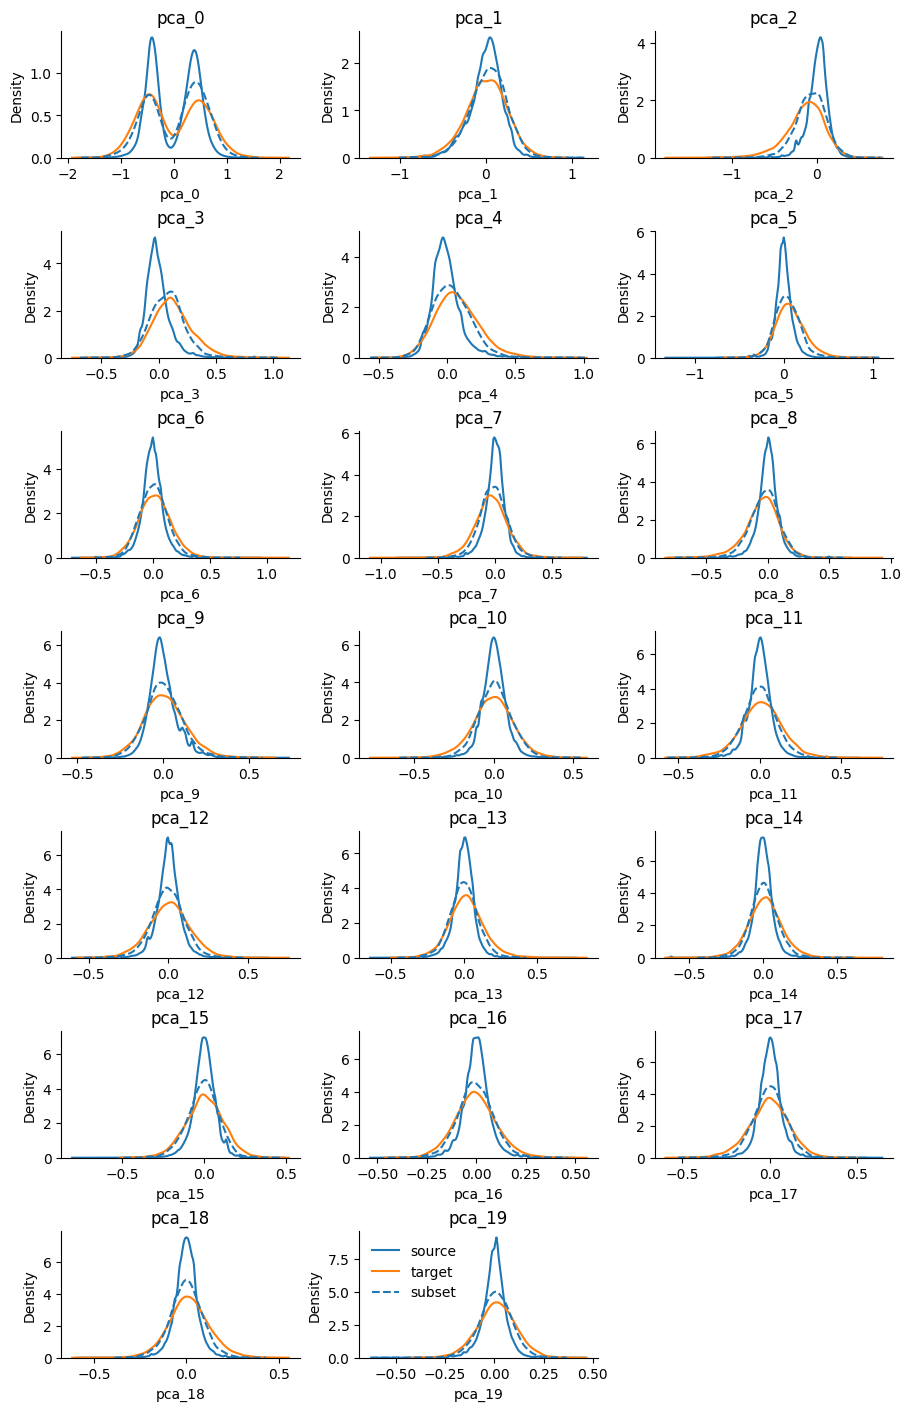

In [29]:
# Run importance sampling 
imp = ImportanceSampler(source=df_source, target=df_target, ignore_cols=ignore_columns)
imp.fit()
df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS)
imp.plot(df_sample, maxcols=3)

In [30]:
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df = summarize_all_metrics(datasets, 
                                   label_col='lang', 
                                   pred_col='predicted_lang', 
                                   average = 'weighted',
                                   n_bootstrap = 1)
print(results_df)

        set     metric      mean     lower     upper
0    Source  precision  0.997076  0.997076  0.997076
1    Source     recall  0.987706  0.987706  0.987706
2    Target  precision  0.981282  0.981282  0.981282
3    Target     recall  0.956148  0.956148  0.956148
4    Sample  precision  0.993817  0.993817  0.993817
5    Sample     recall  0.982800  0.982800  0.982800
6  Weighted  precision  0.990382  0.990382  0.990382
7  Weighted     recall  0.982268  0.982268  0.982268


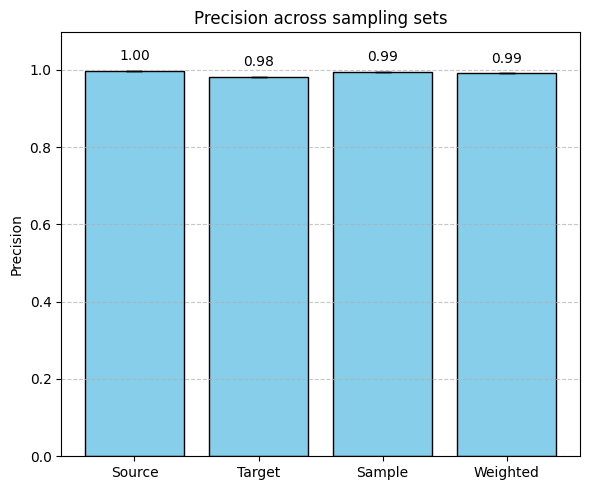

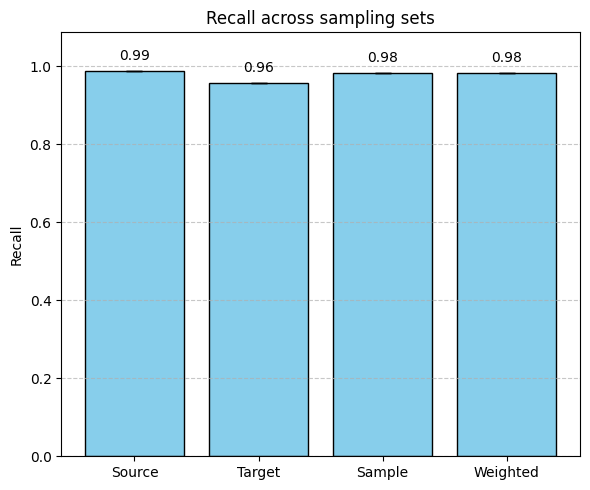

In [31]:
# Plot metrics
plot_metric_bars(results_df, metric="precision", title="Precision across sampling sets")
plot_metric_bars(results_df, metric="recall", title="Recall across sampling sets")

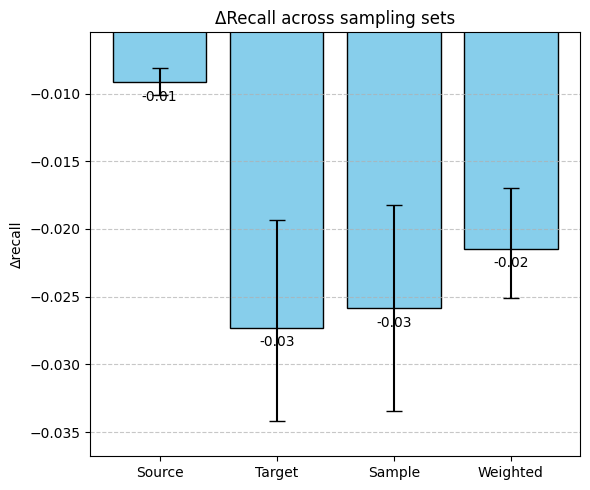

In [32]:
# Compute bootstrap metric differences vs Target
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df = summarize_all_deltas(datasets, 
                                    group_col="lang",
                                    group_a='afr',
                                    group_b='nld',
                                    label_col="lang",
                                    pred_col="predicted_lang",
                                    n_bootstrap=100,
                                    average = 'weighted')

# Plot metrics
plot_metric_bars(results_df, metric="Δrecall", title="ΔRecall across sampling sets")